In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LayerNormalization, MultiHeadAttention, Add, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


In [5]:

# 1. Load data
nifty_data = pd.read_csv("data/NIFTY 50-9-08-2024-to-9-08-2025.csv")
# Standardize column names
nifty_data.columns = nifty_data.columns.str.strip()

nifty_data['Date'] = pd.to_datetime(nifty_data['Date'], dayfirst=True)

nifty_data.sort_values(by='Date', inplace=True)
close_prices = nifty_data['Close'].values.reshape(-1, 1)


/tmp/ipykernel_146522/3405850382.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nifty_data['Date'] = pd.to_datetime(nifty_data['Date'], dayfirst=True)


In [6]:

# 2. Scale data
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)


In [7]:

# 3. Create sequences for time series (common for all models)
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 60
X, y = create_sequences(scaled_close, SEQ_LEN)

# Train-test split (80%)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


In [8]:

# -------------------------
# 1. LSTM Model
# -------------------------
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10)
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

lstm_pred = lstm_model.predict(X_test)
lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)
y_test_rescaled = scaler.inverse_transform(y_test)


Epoch 1/50


2025-08-26 10:14:35.241355: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/rsg-ubu/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0836 - val_loss: 0.0108
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0285 - val_loss: 0.0019
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0195 - val_loss: 0.0337
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0212 - val_loss: 0.0263
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0174 - val_loss: 0.0041
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0185 - val_loss: 0.0023
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0162 - val_loss: 0.0120
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0173 - val_loss: 0.0134
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0146 - val_loss: 0.0083
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0144 - val_loss: 0.0070
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0145 - val_loss: 0.0071
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0128 - val_loss: 0.0065
2/2 ━━━━━━━━

In [12]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    # Add default None to training argument
    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [13]:

def build_transformer_model(seq_len=SEQ_LEN, embed_dim=32, num_heads=2, ff_dim=64):
    inputs = Input(shape=(seq_len, 1))
    # embedding projection
    x = Dense(embed_dim)(inputs)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = Flatten()(x)
    x = Dense(64, activation="relu")(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model


In [14]:

transformer_model = build_transformer_model()
transformer_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

transformer_pred = transformer_model.predict(X_test)
transformer_pred_rescaled = scaler.inverse_transform(transformer_pred)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 6.5819 - val_loss: 3.4521
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6332 - val_loss: 0.6544
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6677 - val_loss: 0.1342
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1269 - val_loss: 0.2089
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1059 - val_loss: 0.0345
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0892 - val_loss: 0.0336
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0515 - val_loss: 0.0864
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0553 - val_loss: 0.0413
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0364 - val_loss: 0.0182
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0318 - val_loss: 0.0253
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


In [15]:

# -------------------------
# 3. N-BEATS Model
# -------------------------
# Custom N-BEATS block
def nbeats_block(input_layer, units, thetas_dim, nb_layers, block_type):
    x = input_layer
    for _ in range(nb_layers):
        x = Dense(units, activation='relu')(x)
    theta = Dense(thetas_dim, activation='linear')(x)
    
    if block_type == 'trend':
        t = tf.linspace(0.0, 1.0, SEQ_LEN)
        p1, p2 = tf.unstack(theta, axis=-1)
        trend = p1[:, None] * t + p2[:, None]
        return trend
    elif block_type == 'seasonality':
        p = theta
        s1 = tf.math.cos(2 * np.pi * tf.linspace(0.0, 1.0, SEQ_LEN)[:, None] * tf.range(thetas_dim, dtype=tf.float32)[None, :])
        seasonality = tf.matmul(s1, tf.transpose(p))
        seasonality = tf.transpose(seasonality)
        return seasonality
    else:
        # generic block output (identity)
        return theta


In [18]:
from tensorflow.keras.layers import Layer

class SeasonalityLayer(Layer):
    def __init__(self, thetas_dim, seq_len, **kwargs):
        super(SeasonalityLayer, self).__init__(**kwargs)
        self.thetas_dim = thetas_dim
        self.seq_len = seq_len
        self.freqs = tf.range(thetas_dim, dtype=tf.float32)  # frequencies

    def call(self, theta):
        # theta shape: (batch_size, thetas_dim)
        batch_size = tf.shape(theta)[0]
        t = tf.linspace(0.0, 1.0, self.seq_len)  # shape (seq_len,)
        t = tf.expand_dims(t, axis=-1)           # (seq_len, 1)
        freqs = tf.expand_dims(self.freqs, axis=0)  # (1, thetas_dim)
        cos_matrix = tf.math.cos(2 * np.pi * t * freqs)  # (seq_len, thetas_dim)
        # multiply theta with cos_matrix
        seasonality = tf.matmul(cos_matrix, theta, transpose_b=True)  # (seq_len, batch_size)
        seasonality = tf.transpose(seasonality)  # (batch_size, seq_len)
        seasonality = tf.expand_dims(seasonality, axis=-1)  # (batch_size, seq_len, 1)
        return seasonality

def build_nbeats_model(input_shape=(SEQ_LEN, 1)):
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)

    # Trend block
    trend_block = Dense(128, activation='relu')(x)
    trend_block = Dense(64, activation='relu')(trend_block)
    trend_theta = Dense(2)(trend_block)
    t = tf.linspace(0.0, 1.0, SEQ_LEN)
    trend = trend_theta[:, 0:1] * t + trend_theta[:, 1:2]  # Broadcasting

    # Seasonality block
    season_block = Dense(128, activation='relu')(x)
    season_block = Dense(64, activation='relu')(season_block)
    season_theta = Dense(10)(season_block)
    seasonality = SeasonalityLayer(thetas_dim=10, seq_len=SEQ_LEN)(season_theta)

    # Sum blocks and reduce
    total = trend[:, :, None] + seasonality  # shape (batch, seq_len, 1)
    total = Flatten()(total)
    outputs = Dense(1)(total)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model


In [19]:

nbeats_model = build_nbeats_model()
nbeats_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

nbeats_pred = nbeats_model.predict(X_test)
nbeats_pred_rescaled = scaler.inverse_transform(nbeats_pred.reshape(-1,1))


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.3861 - val_loss: 0.0683
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1884 - val_loss: 0.2612
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1129 - val_loss: 0.1691
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0859 - val_loss: 0.0211
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0429 - val_loss: 0.0374
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0194 - val_loss: 0.0135
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0193 - val_loss: 0.0473
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0160 - val_loss: 0.0101
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0075 - val_loss: 0.0147
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distrib

In [20]:

# -------------------------
# Evaluation
# -------------------------
def evaluate_preds(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Performance:\n MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}\n")

evaluate_preds(y_test_rescaled, lstm_pred_rescaled, "LSTM")
evaluate_preds(y_test_rescaled, transformer_pred_rescaled, "Transformer")
evaluate_preds(y_test_rescaled, nbeats_pred_rescaled, "N-BEATS")



LSTM Performance:
 MAE: 309.3742, MSE: 158085.5846, R2: -0.4376

Transformer Performance:
 MAE: 390.1458, MSE: 263200.1695, R2: -1.3935

N-BEATS Performance:
 MAE: 540.3892, MSE: 388651.1501, R2: -2.5344



In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(y_true, y_pred, name):
    return {
        "Model": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
        "MAPE%": np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }

results = [
    evaluate_model(y_test_rescaled, lstm_pred_rescaled, "LSTM"),
    evaluate_model(y_test_rescaled, transformer_pred_rescaled, "Transformer"),
    evaluate_model(y_test_rescaled, nbeats_pred_rescaled, "N-BEATS")
]

df_results = pd.DataFrame(results)
print(df_results)


         Model         MAE        RMSE        R2     MAPE%
0         LSTM  309.374178  397.599779 -0.437625  1.223007
1  Transformer  390.145847  513.030379 -1.393534  1.541747
2      N-BEATS  540.389196  623.418920 -2.534382  2.153711


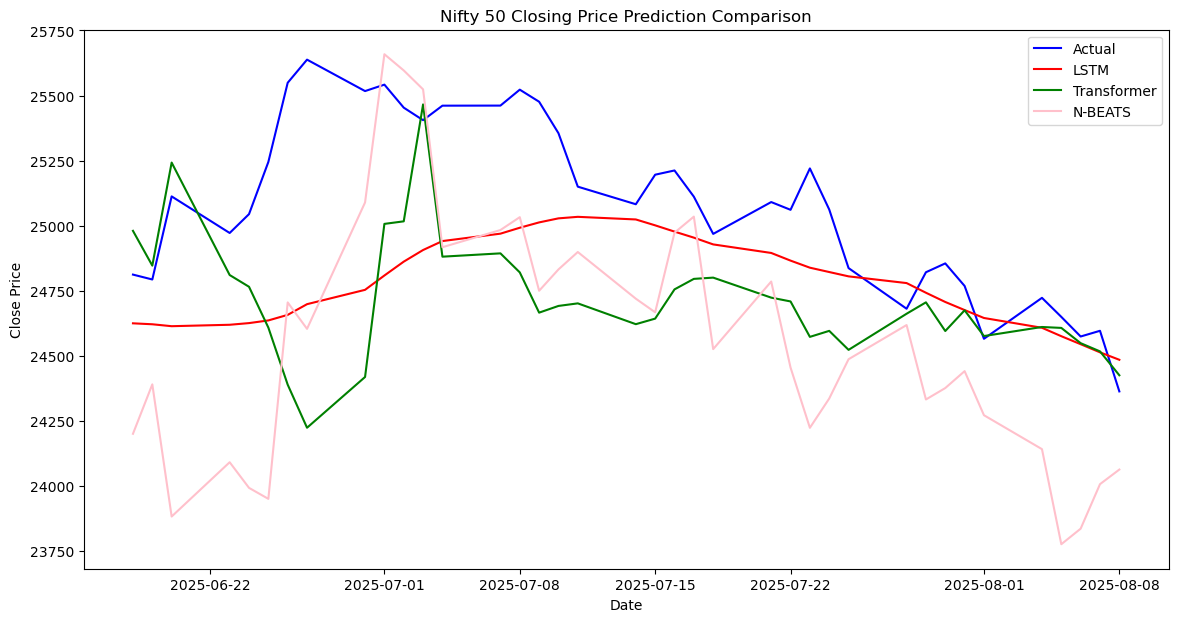

In [23]:

# -------------------------
# Plot predictions
# -------------------------
dates_test = nifty_data['Date'][len(nifty_data) - len(y_test):]

plt.figure(figsize=(14, 7))
plt.plot(dates_test, y_test_rescaled, label='Actual', color='blue')
plt.plot(dates_test, lstm_pred_rescaled, label='LSTM', color='red')
plt.plot(dates_test, transformer_pred_rescaled, label='Transformer', color='green')
plt.plot(dates_test, nbeats_pred_rescaled, label='N-BEATS', color='pink')
plt.title('Nifty 50 Closing Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
